In [29]:
import pandas as pd
import numpy as np
import ast
import os
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../..')
from modules.many_features import utils, constants
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
SEED = 147
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

#### X_test

In [31]:
# test_set = pd.read_csv('../../data/more_features/train_sets/test_set_constant.csv')
test_set = pd.read_csv('../../../anemia_ml4hc/data/test_set_constant.csv')
X_test = test_set.iloc[:, 0:-1]
y_test = test_set.iloc[:, -1]
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((14000, 17), (14000,))

In [32]:
# df['label'] = df['label'].replace(class_dict)
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
# test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
# # X_train, y_train = np.array(X_train), np.array(y_train)
# # X_test, y_test = np.array(X_test), np.array(y_test)
# test_set.shape

In [33]:
test_set.head()

,hemoglobin,ferritin,ret_count,segmented_neutrophils,tibc,mcv,serum_iron,rbc,gender,creatinine,cholestrol,copper,ethanol,folate,glucose,hematocrit,tsat,label
0,7.116363,-1.000000,3.781573,2.738413,-1.000000,95.904198,68.457895,2.226085,0,1.892912,39.808550,110.329197,64.404350,21.654404,73.787009,21.349089,-1.000000,5
1,8.125320,92.230003,4.231419,1.188039,143.365567,104.057204,204.747831,2.342554,0,0.652614,13.478089,-1.000000,32.705481,-1.000000,43.520272,24.375961,142.815207,1
2,11.309450,38.324563,-1.000000,-1.000000,455.077909,76.402602,-1.000000,4.440732,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,33.928350,-1.000000,4
3,13.763858,253.513394,2.262606,0.551444,453.772884,82.781943,90.101466,4.987993,0,0.853521,104.005514,34.639227,0.963866,22.083012,88.891838,41.291574,19.856071,0
4,11.464002,-1.000000,-1.000000,-1.000000,320.964653,104.287127,-1.000000,3.297819,0,1.163516,121.616315,105.895897,-1.000000,9.337462,-1.000000,34.392007,-1.000000,7


#### test_df

In [34]:
# test_df =pd.read_csv('../../test_dfs/many_features/0.1/correlated/constant_test_set/test_df_noisy6_17000000.csv')
test_df = pd.read_csv('../../../anemia_ml4hc/test_dfs/dueling_dqn_pr_test_df_seed_147_10000000.csv')
test_df.head()

,index,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
0,0.0,4.0,1.0,5.0,5.0,"['hemoglobin', 'rbc', 'ret_count', 'Hemolytic ...",0.0,1.0
1,1.0,4.0,1.0,1.0,1.0,"['hemoglobin', 'rbc', 'segmented_neutrophils',...",0.0,1.0
2,2.0,6.0,1.0,4.0,4.0,"['hemoglobin', 'gender', 'rbc', 'ferritin', 't...",0.0,1.0
3,3.0,2.0,1.0,0.0,0.0,"['hemoglobin', 'No anemia']",0.0,1.0
4,4.0,5.0,-1.0,7.0,7.0,"['hemoglobin', 'gender', 'rbc', 'segmented_neu...",1.0,1.0


In [35]:
utils.test(test_df.y_actual, test_df.y_pred)

(97.20714285714286, 97.09763295502441, 98.42156225103214)

In [36]:
test_set.label.unique()

array([5, 1, 4, 0, 7, 2, 3, 6])

In [37]:
len(test_df)

14000

In [38]:
test_df.y_pred.value_counts()

0.0    1968
1.0    1965
2.0    1795
3.0    1771
6.0    1705
5.0    1673
4.0    1634
7.0    1489
Name: y_pred, dtype: int64

In [39]:
def get_idx_df(target_df, idx_list):
    idx_df = target_df.iloc[idx_list]
    return idx_df

In [40]:
def get_distribution(df, feat): #df = anemia_test_df feat = where branching happens and whose value distribution we desire
    feat_dict = get_indices(df, feat)
    next_feat_df_dict = {}
    for i, next_feat in enumerate(list(feat_dict.keys())):
        next_feat_df = get_idx_df(test_set, feat_dict[next_feat])
        next_feat_df_dict[next_feat] = next_feat_df[feat]
    combined_df = pd.DataFrame(next_feat_df_dict)
#     print(combined_df)
    sns.set_style('dark')
    gfg = sns.boxplot(data = combined_df, palette='pastel')
    gfg.set(ylabel = feat, title = f'{feat} value distribution')
    plt.xticks(rotation=90)
    sns.despine()
    plt.show()    
    return combined_df

In [41]:
def get_indices(df, feat): #get indices in  df where feature is in pathway
    idx_dict = {}
    for i, row in df.iterrows():
        pathway = ast.literal_eval(row['trajectory'])
        if feat in pathway:
            feat_idx = pathway.index(feat)
            next_element = pathway[feat_idx+1]
            if next_element not in list(idx_dict.keys()):
                idx_dict[next_element] = [row.name]
            else:
                idx_dict[next_element].append(row.name)
    return idx_dict

#### delete from here

In [ ]:
terminated_df = test_df[test_df.y_pred.isna()]

In [ ]:
idx_dict = {}
feat = 'mcv'
count = 0
for i, row in terminated_df.iterrows():
    pathway = ast.literal_eval(row['trajectory'])
    if feat in pathway:
        feat_idx = pathway.index(feat)
        next_element = pathway[feat_idx+1]
        if next_element == feat:
            count+=1
count

In [ ]:
feat_dict = get_indices(terminated_df, 'ret_count')
feat_dict.keys()

In [ ]:
len(feat_dict['mcv'])

#### end here

#### 0 - No anemia - predicted as

In [42]:
no_num = 0
no_df = test_df[test_df.y_pred == no_num]
no_df.head()

,index,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
3,3.0,2.0,1.0,0.0,0.0,"['hemoglobin', 'No anemia']",0.0,1.0
9,9.0,3.0,1.0,0.0,0.0,"['hemoglobin', 'gender', 'No anemia']",0.0,1.0
17,17.0,2.0,1.0,0.0,0.0,"['hemoglobin', 'No anemia']",0.0,1.0
21,21.0,2.0,1.0,0.0,0.0,"['hemoglobin', 'No anemia']",0.0,1.0
32,32.0,2.0,1.0,0.0,0.0,"['hemoglobin', 'No anemia']",0.0,1.0


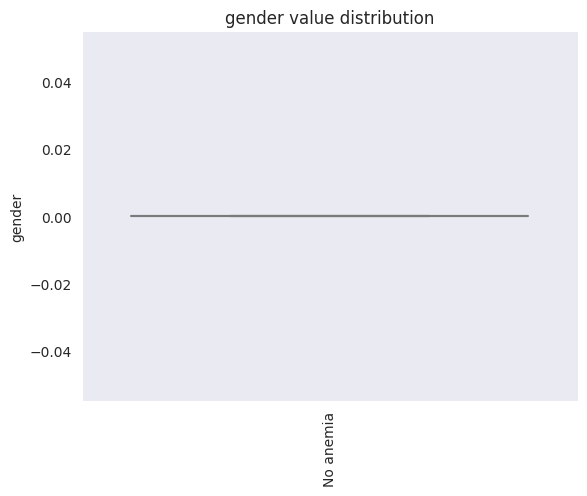

In [44]:
no_hb_distribution = get_distribution(no_df, 'gender')

In [ ]:
#no_mcv_distribution = get_distribution(no_df, 'mcv')

In [ ]:
#hemolytic_ferritin_distribution = get_distribution(hemolytic_df, 'ferritin')

#### 1 - Vitamin B12/Folate deficiency anemia

In [ ]:
vitamin_num = 1
vitamin_df = test_df[test_df.y_pred == vitamin_num]
vitamin_recall_df = test_df[test_df.y_actual == vitamin_num]
vitamin_df.head()

In [ ]:
vitamin_mcv_distribution = get_distribution(vitamin_df, 'rbc')

#### 2 - Unspecified anemia

In [ ]:
unspecified_num = 2
unspecified_df = test_df[test_df.y_pred == unspecified_num]
unspecified_df.head()

In [ ]:
len(unspecified_df)

In [ ]:
aplastic_mcv_distribution = get_distribution(unspecified_df, 'mcv')

#### 3 - Anemia of chronic disease

In [ ]:
acd_num = 3
acd_df = test_df[test_df.y_pred == acd_num]
acd_df.head()

In [ ]:
acd_mcv_distribution = get_distribution(acd_df, 'ferritin') #no branching

#### 4 - Iron deficiency anemia

In [ ]:
ida_num = 4
ida_df = test_df[test_df.y_pred == ida_num]
ida_df.head()

In [ ]:
ida_mcv_distribution = get_distribution(ida_df, 'ferritin') #no branching

#### 5 - Hemolytic anemia

In [45]:
hemolytic_num = 5
hemolytic_df = test_df[(test_df.y_pred==hemolytic_num)]

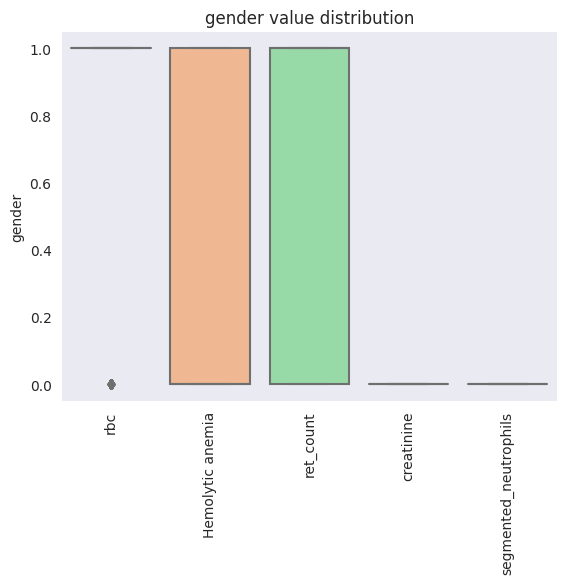

In [48]:
hemolytic_mcv_distribution = get_distribution(hemolytic_df, 'gender')

#### 6 -  Aplastic anemia

In [23]:
aplastic_num = 6
aplastic_df = test_df[test_df.y_pred == aplastic_num]
aplastic_df.head()

,index,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
15,15.0,5.0,1.0,6.0,6.0,"['hemoglobin', 'mcv', 'ret_count', 'rbc', 'Apl...",0.0,1.0
22,22.0,5.0,1.0,6.0,6.0,"['hemoglobin', 'mcv', 'ret_count', 'rbc', 'Apl...",0.0,1.0
26,26.0,5.0,1.0,6.0,6.0,"['hemoglobin', 'mcv', 'ret_count', 'rbc', 'Apl...",0.0,1.0
48,48.0,5.0,1.0,6.0,6.0,"['hemoglobin', 'mcv', 'ret_count', 'gender', '...",0.0,1.0
53,53.0,5.0,1.0,6.0,6.0,"['hemoglobin', 'mcv', 'ret_count', 'rbc', 'Apl...",0.0,1.0


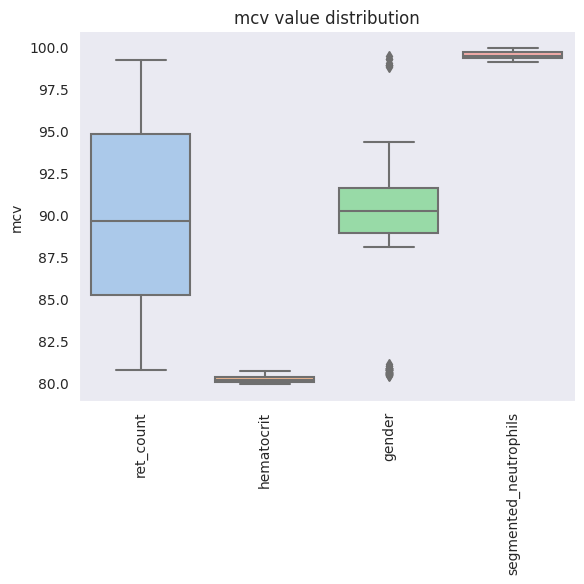

In [28]:
aplastic_mcv_distribution = get_distribution(aplastic_df, 'mcv')

#### Inconclusive diagnosis

In [ ]:
inconclusive_num = 7
inconclusive_df = test_df[test_df.y_pred == inconclusive_num]
inconclusive_df.head()

In [ ]:
inconclusive_mcv_distribution = get_distribution(inconclusive_df, 'mcv')